# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цель исследования:**
1. Научиться определять рыночную стоимость объектов недвижимости
2. Установить параметры от которых зависит цена квартир 
3. Построить автоматизированную систему: она отследит аномалии и мошенническую деятельность
  
   **Ход исследования**
    - Извлечь данные из файла и оценить их качество. 
    - Провести предобработку: изучить выбросы и принять решение о необходимости их удаления, оценить масштаб отсутствующих значений и выбрать наиболее корретный способ их заполнения(если это возможно).
    - Добавить новые столбцы с расчетами дополнительных параметров 
    - Изучить факторы, влияющие на ценообразование, построить наглядные зависимости 
    - Написать общий вывода по проделанной работе

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd 
import seaborn as sns

In [2]:
data = pd.read_csv('/Users/alinanaumova/Desktop/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Итак, мы имеем 22 колонки с данными:  
- Чиловые:
 - airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
 - balcony — число балконов
 - ceiling_height — высота потолков (м)
 - cityCenters_nearest — расстояние до центра города (м)
 - days_exposition — сколько дней было размещено объявление (от публикации до снятия)
 - floor — этаж
 - floors_total — всего этажей в доме
 - kitchen_area — площадь кухни в квадратных метрах (м²)
 - last_price — цена на момент снятия с публикации
 - living_area — жилая площадь в квадратных метрах (м²)
 - parks_around3000 — число парков в радиусе 3 км
 - parks_nearest — расстояние до ближайшего парка (м)
 - ponds_around3000 — число водоёмов в радиусе 3 км
 - ponds_nearest — расстояние до ближайшего водоёма (м)
 - rooms — число комнат 
 - total_area — общая площадь квартиры в квадратных метрах (м²)
 - total_images — число фотографий квартиры в объявлении 
- Текстовые: 
 - first_day_exposition — дата публикации
 - locality_name — название населённого пункта
- Категориальные:
 - open_plan — свободная планировка (булев тип)
 - is_apartment — апартаменты (булев тип)
 - studio — квартира-студия (булев тип)

В 14 из них есть пропуски, их довольно большое количество

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Посмотрим на общую картину значений по гистограммам

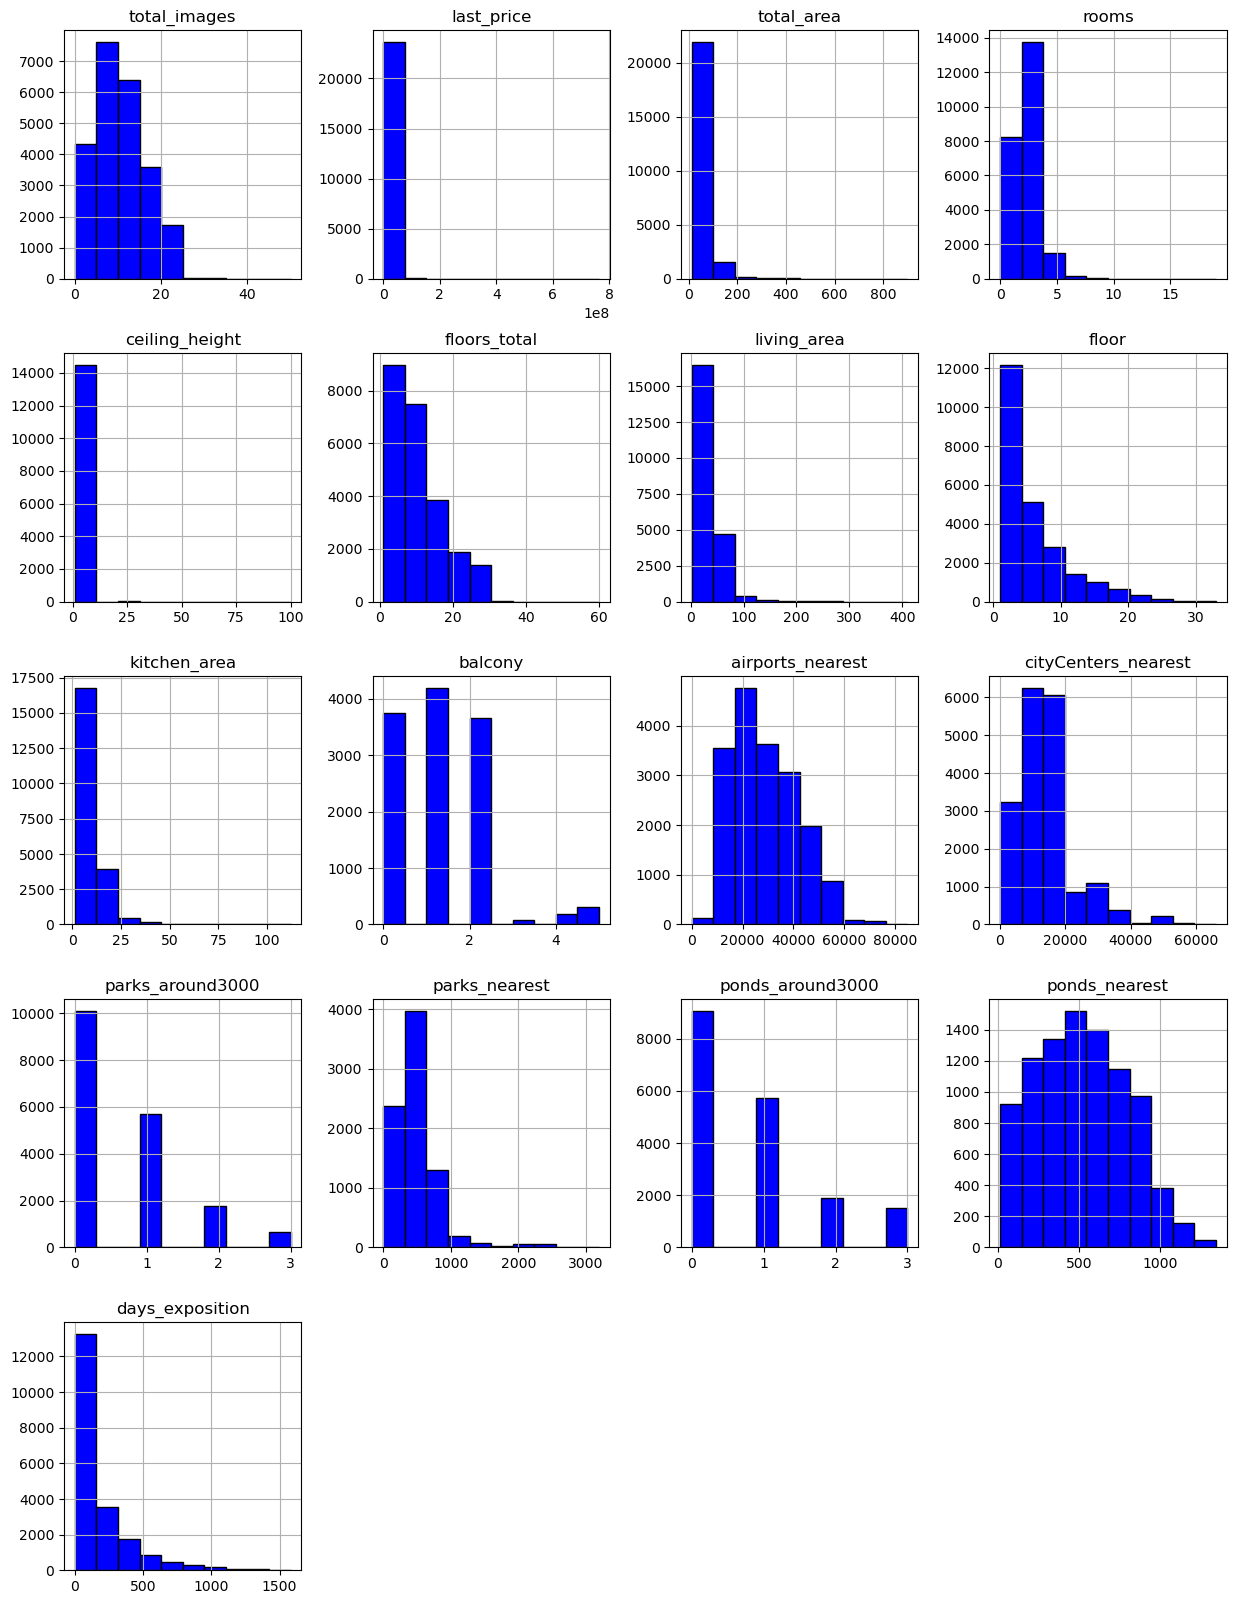

In [6]:
data.hist(figsize = (15,20), color = 'blue', edgecolor = 'black');

Ого! Почти во всех числовых столбцах есть выбросы, надо это исправлять. Тактика примерно следующая: вначале обработаем все пропуски и посмотрим на выбросы, после этого почистим таблицу и будем изучать данные более детально.

### Предобработка данных

**Населенные пункты**

Для дальнейшего удобства начнем с приведения в порядок названия населенных пунктов. Проверим отсутсвтвующие значения и удалим неявные дубликаты

In [7]:
#посчитаем количество незаполненных нас.пунктов
data['locality_name'].isna().sum()

49

In [8]:
#пока что не будем спешить и удалять пропуски, заменим их на 'неизвестно'
#отфильтруем все уникальные значения
data['locality_name'] = data['locality_name'].fillna('Неизвестно')
sorted(data['locality_name'].unique())

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Неизвестно',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровс

In [9]:
#количество уникальных значений на данный момент 
len(data['locality_name'].unique()) 

365

In [10]:
#словарь для замены типа населенного пункта
rename = {
    'посёлок': 'поселок',
    'поселок городского типа': 'поселок',
    'посёлок городского типа': 'поселок',
    'коттеджный поселок': 'поселок',
    'коттеджный посёлок': 'поселок',
    'городской поселок': 'поселок',
    'городской посёлок': 'поселок',
    'поселок станции': 'поселок',
    'посёлок станции': 'поселок',
    'посёлок при железнодорожной станции': 'поселок',
    'поселок при железнодорожной станции': 'поселок',
    'садоводческое некоммерческое товарищество': 'садовое товарищество',
    'поселок городского типа имени': 'поселок',
    'поселок имени': 'поселок',    
}

In [11]:
#функция чтобы заменить тип нас.пункта из нашего списка на ключи словаря
def rename_func(name):
    for key, value in rename.items():
        name = name.replace(key, value)
    return name

In [12]:
data['locality_name'] = data['locality_name'].apply(rename_func)
sorted(data['locality_name'].unique())

['Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Неизвестно',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'деревня Агалатово',
 'деревня Аро',
 'деревня Батово',
 'деревня Бегуницы',
 'деревня Белогорка',
 'деревня Большая Вруда',
 'деревня Большая Пустомержа',
 'деревня Большие Колпаны',
 'деревня Большое Рейзино',
 'деревня Большой Сабск',
 'деревня Бор',
 'деревня Борисова Грива',
 'деревня Ваганово',
 'деревня Вартемяги',
 'деревня Вахнова Кара',
 'деревня Выскатка',
 'деревня Гарболово',
 'дере

In [13]:
len(data['locality_name'].unique()) 

319

Таким образом мы убрали пропуски из названия населенных пунктов и избавились от самых явных дубликатов, сократив количество уникальных значений с 365 до 319. 

**Высота потолков**

In [14]:
#Начнем исследовать нулевые и аномальные значения по порядку столбцов. 
#Прежде чем решить, что делать с пропусками посмотрим на уникальные значния
sorted(data['ceiling_height'].unique())

[1.0,
 2.0,
 2.3,
 2.4,
 2.45,
 2.46,
 2.48,
 2.53,
 2.59,
 2.62,
 2.63,
 2.7,
 nan,
 1.2,
 1.75,
 2.2,
 2.25,
 2.34,
 2.47,
 2.49,
 2.5,
 2.51,
 2.52,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.6,
 2.61,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,
 3.9,
 3.93,
 3.95,


В первую очередь обработаем значения от 20 до 32 м, скорее всего здесь просто опечатка и и подразумевалось 2 - 3,2.

In [15]:
data.loc[(data['ceiling_height']>=20.0) & (data['ceiling_height']<100.0), 'ceiling_height'] = data['ceiling_height']/10
sorted(data['ceiling_height'].unique())

[1.0,
 1.2,
 1.75,
 2.0,
 2.2,
 2.25,
 2.2600000000000002,
 2.7,
 nan,
 2.3,
 2.34,
 2.4,
 2.45,
 2.46,
 2.47,
 2.48,
 2.49,
 2.5,
 2.51,
 2.52,
 2.53,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.59,
 2.6,
 2.61,
 2.62,
 2.63,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,

Видно, что очень много значений выше 3 метров, что свойственно для домов "старого фонда", "сталинках" или элитной недвижимости. Однако, изучив пару-тройку статей на просторах интренета можно найти информацию, высота потолков в старом фонде обычно не превышала 3,6 метра, но в сталинках могла доходить до 4,5 метров. Отличительная особенность последних - они находятся только в самом городе. Посмотрим так ли это

In [16]:
data.query('ceiling_height > 3.6').pivot_table(index='locality_name', values='ceiling_height', aggfunc='count')

,ceiling_height
locality_name,
Бокситогорск,1
Всеволожск,2
Выборг,4
Гатчина,1
Красное Село,1
Кронштадт,2
Ломоносов,1
Неизвестно,1
Пушкин,5


In [17]:
#проверяем что осталось если мы убираем значения из Спб
data.query('ceiling_height > 3.6 and locality_name != "Санкт-Петербург"').value_counts('ceiling_height')

ceiling_height
4.00    8
3.70    2
3.95    2
4.20    2
4.50    2
8.00    2
3.62    1
3.75    1
3.80    1
3.83    1
5.00    1
dtype: int64

Почти все значения оказались в городской черте, что дает нам основание считать это нормой. 23 объекта загородом оставим на загородные ЖК. 
Итого, у нас остаются значения меньше 2 метров и свыше 4,5. 
Заполним все данные медианными значениями по региону где это возможно, если ее нет - общей, а потом строки, где меньше 2х метров мы удаляем однозначно, тк не бывает таких низких потолков, а вот для больших значений убедимся, что никто не умножил к-во комнат на высоту потолка. Если это так - строки останутся, если нет - все некорректые значения отсеиваем отбором.

In [18]:
for locality_name in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == locality_name,'ceiling_height'].median()
    data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] == locality_name), 'ceilng_height'] = median
    
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()

In [19]:
#делим высоту на к-во компнат не равных 0, если все ок, значит оставляем, нет - выкидываем
data.loc[(data['ceiling_height'] > 4.5) & (data['rooms'] != 0), ['ceiling_height']] \
= data['ceiling_height']/data['rooms']

**Дата публицкации и количество дней размещения объявления**

Проверим даты публикаций на выбросы, для этого приведем значения в колонке к типу datetime, параллельно посмотрим на выбросы и пропуски в количестве дней размещения, и приведем значения к целому числу.

In [20]:
#Посмотрим на первые 5 строк, чтобы понять в каком формате записана дата в данный момент
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceilng_height
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,NaN,...,2.0,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2.63
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,NaN,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2.70
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2.70
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,NaN


In [21]:
#переведем дату и время к типу datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceilng_height
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,NaN,...,2.0,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2.63
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,NaN,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2.70
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,NaN,9,NaN,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2.70
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,NaN


In [22]:
#Созданим новый столбец со значением года публикации объявления
data['first_day_exposition_year'] = data['first_day_exposition'].dt.year
data['first_day_exposition_year']

0        2019
1        2018
2        2015
3        2015
4        2018
         ... 
23694    2017
23695    2018
23696    2018
23697    2017
23698    2017
Name: first_day_exposition_year, Length: 23699, dtype: int64

In [23]:
#для оценки к-ва пропусков по годам сделаем своднудную таблицу для заполненых значений, а потом наглядно сравним ее с пропусками
days_exposition = data.pivot_table(index='first_day_exposition_year', values='days_exposition', aggfunc='count')
days_exposition['all_values'] = data['first_day_exposition_year'].value_counts()
days_exposition['difference'] = data['first_day_exposition_year'].value_counts() - days_exposition['days_exposition']
days_exposition

,days_exposition,all_values,difference
first_day_exposition_year,,,
2014,119,137,18
2015,1121,1191,70
2016,2716,2783,67
2017,7919,8190,271
2018,7560,8519,959
2019,1083,2879,1796


Как видно в таблице, мы имеем крайне небольшие значения по 2014 году, а также больше половины незаполненных значений по 2019 году. Скорее всего, последнее связано с тем, что на момент сбора данных не посчитали разницу между этой датой и датой объявления. Проверим к-во дней размещения на выбросы

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

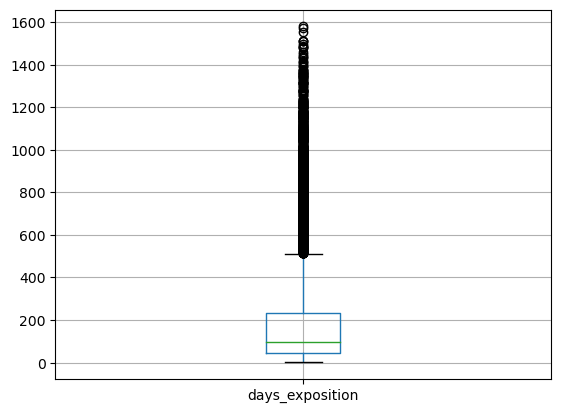

In [24]:
data.boxplot(['days_exposition'])
data['days_exposition'].describe()

Очень неоднозначные данные, 1 день и 4,5 года на продажу квартиры. Первое больше похоже на то, что объявление выставили, возможно, ошибочно, а второе - как будто про него и вовсе забыли. Посмотрим на данные, я бы ограничилась временем от 5 дней до 3 лет

In [25]:
(data.loc[(data['days_exposition'] > 1095)].value_counts('days_exposition')).sum()

166

In [26]:
(data.loc[(data['days_exposition'] < 5)].value_counts('days_exposition')).sum()

338

Большое количество строк определяется как выбросы, но продажа недвижимости очень сложное дело, поэтому не стоит удалять такой большой объем информации. Пропуски в значениях оставим как есть, а данные за 2014 год и, провисевшие меньше 5 дней/больше 3х, лет удалим

**Этаж и всего этажей в доме**

Для начала посмотрим на размах по этажности домов и квартир. По данным за до 18 года самая высокая медианная этажность в Лен области составляла около 20 этажей, а в самом Петербурге самый высокий ЖК насчитывает 37 этажей, надо проанализировать все что выходит за рамки. Далее уберем или заполним пропуски в данных. Затем изменим тип данных в столбце со всеми этажами в доме, тк это однозначно должно быть целое число. 

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

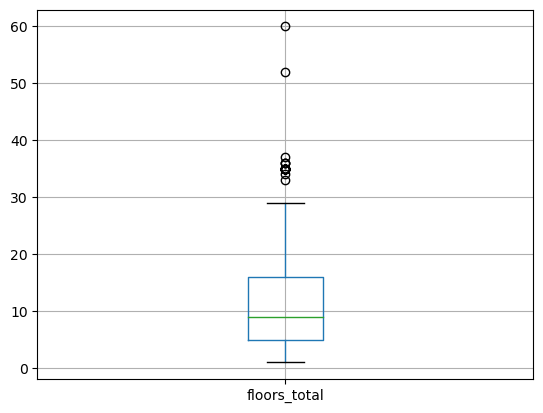

In [27]:
data.boxplot(['floors_total'])
data['floors_total'].describe()

По диаграмме видно, что выбросами являются значения больше 29 этажей, надо узнать, сколько это в числовом выражении

In [28]:
(data.loc[data['floors_total'] > 29.0, 'floors_total']).count()

32

Сразу взгянем на пропуски и явные несостыковки этажности дома и этажа недвижимости

In [29]:
data['floors_total'].isna().sum()

86

In [30]:
data.loc[data['floors_total'] < data['floor']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceilng_height,first_day_exposition_year


Отлично, у нас нет домов, в котором квартира выше здания! 
В сумме 118 строк состоят из выбросов и пустых значений, меньше 0,5% от общего числа данных, проще удалить.

Теперь посмотрим что с этажами у квартир в целом

<AxesSubplot:>

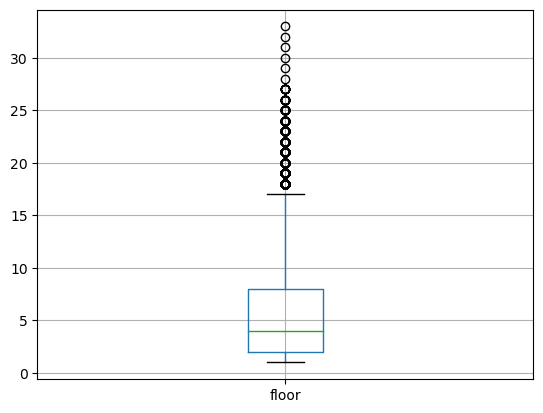

In [31]:
data.boxplot(['floor'])

Выбросы начинаются около 17 этажа, взглянем на цифры

In [32]:
(data.loc[data['floor'] > 17, 'floor']).value_counts().sum()

922

Достаточно, но не очень много больших значений, имеет смысл проверить их местоположение

In [33]:
data.loc[data['floor'] > 17].value_counts('locality_name')

locality_name
Санкт-Петербург            628
поселок Парголово           89
поселок Мурино              81
поселок Шушары              41
деревня Кудрово             39
Кудрово                     20
поселок Бугры                6
Мурино                       5
Неизвестно                   4
Колпино                      2
Никольское                   2
деревня Новое Девяткино      2
Всеволожск                   1
Сестрорецк                   1
поселок Дубровка             1
dtype: int64

Большинство находятся в Спб или районах, которые активно застраивались и продолжают застраиваться, оставим все без изменений.

**Жилая площадь и площадь кухни**

По логике площадь кухни и жилая площадь напрямую зависят от общей площади квартиры, поэтому целесообразно в этом убедиться, на всякий случай. 
Затем проверим все площади на выбросы и обработаем пустые значения

In [34]:
#проверяем корреляцию
print(data['living_area'].corr(data['total_area']))
data['kitchen_area'].corr(data['total_area'])

0.9395373338721493


0.6091211711198316

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

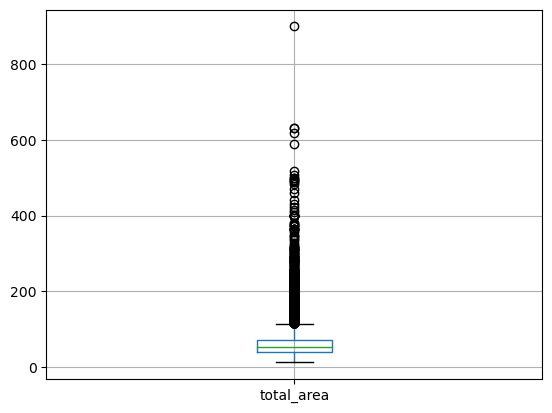

In [35]:
#смотрим выбросы
data.boxplot(['total_area'])
data['total_area'].describe()

Ого! Квартира площадью в 900 м2! Что-то тут не чисто, еще и кроха в 12 метров, возможно просто комната

In [36]:
#посмотрим на квартиры площадью больше 100 метров
data.loc[data['total_area'] > 100].value_counts('total_area').count()

660

In [37]:
#посмотрим на квартиры площадью меньше 20 метров
data.loc[data['total_area'] < 20].value_counts('total_area').count()

18

In [38]:
#уж не студии ли это 
data.loc[data['total_area'] < 20, ['studio']].sum()

studio    7
dtype: int64

6 квартир не студий с площадью меньше 20 метров, звучит не очень правдоподобно. 

660 квартир с площадью больше 100 метров это интересно, посмотрим, увидим ли мы что-то похожее, если сложим площади кухонь и жилых помещений

In [39]:
data.loc[(data['living_area'] + data['kitchen_area']) > 100.0].value_counts('total_area').sum()

639

660 против 639 с учетом того, что в кухне и жилых площадях есть пропуски. Оставим все как есть, удалим строчечку с 900 м2, ну уж слишком шикарная квартира, подпортит нам все карты, а еще почистим строки с площадью меньше 20 метров и не студии. Взглянем что с пропусками

In [40]:
print(data['living_area'].isna().sum())
data['kitchen_area'].isna().sum()

1903


2278

Внушительная нехватка значений, для простоты можем сделать следующее: тк, жилая площадь практически полностью зависит от общей, найдем медианное значение этой зависимости и разделим общуюю площадь на ее значение; кухня менее зависима, там просто подставим медианное значение.

In [41]:
data_area_median = (data['total_area']/data['living_area']).median()

In [42]:
data['living_area'] = data['living_area'].fillna(data['total_area']/data_area_median)
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())

**Аппартаменты**

Тут, я считаю, все просто: аппартаменты или есть, или их нет, если в объявлении не было такого указано, значит данный тип недвижимости аппартаментами не является. Заменяем пропуски на ложь

In [43]:
data['is_apartment'] = data['is_apartment'].fillna(False)

**Балконы**

С балконами ситуация немного похожа на историю с аппартаментами, однако, мы не можем никак ни подтвердить, ни опровергнуть информацию о том, есть ли балконы там, где значения пропущены. Считаю логичным, в данном случае, заполнить их количество 0. И заменим тип данных на целое число, полтора балкона - некрасиво

In [44]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype(int)

**Картографические данные**

In [45]:
#посмотрим на данные прежде, чем делать предположения
data_cartography = ['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']
data[data_cartography].describe()

,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
count,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000
mean,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900
std,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643
min,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000
25%,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000
50%,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000
75%,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000
max,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000


БОльшая часть данных отсутсвует. В реальности мы бы отдали это на переделку или с помощью супер силы сами бы заполнили подобные пропуски, но в данным момент это не представляется возможным, оставим все как есть.

**Оставшиеся выбросы**

Из всего объема данных мы не проверили только к-во комнат в помещениях, к-во фотографий и цену на выбросы, пора это сделать

In [46]:
#посмотрим вначале на цены
np.round(data['last_price'].describe())

count        23699.0
mean       6541549.0
std       10887013.0
min          12190.0
25%        3400000.0
50%        4650000.0
75%        6800000.0
max      763000000.0
Name: last_price, dtype: float64

In [47]:
np.round(data.loc[data['last_price'] > 50000000, 'last_price']).count()

131

In [48]:
np.round(data.loc[data['last_price'] < 1000000, 'last_price']).count()

225

131 квартира дороже 50 миллионов и 225 дешевле миллиона, посмотрим на их местоположение и общую площадь

In [49]:
data.loc[(data['last_price'] > 50000000) & (data['locality_name'] != "Санкт-Петербург")]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceilng_height,first_day_exposition_year


In [50]:
data.loc[data['last_price']  > 50000000, 'total_area'].median()

230.0

In [51]:
data.loc[data['last_price'] > 50000000, 'total_area'].median()

230.0

Нууу, в целом, я думаю такие данные имеют право на существование, мы же оцениваем весь рынок недвижимости, а не среднестатистические квартиры. Что там с квартирами по цене ниже стоимости новенькой лады?

In [52]:
data.loc[(data['last_price'] < 1000000) & (data['locality_name'] != "Санкт-Петербург"), 'last_price'].count()

224

In [53]:
data.loc[data['last_price']  < 1000000, 'total_area'].median()

41.0

Я не сильна в ценах на квартиры, но что-то мне подсказывает, что если это далеко от города и с не очень большой площадью(а еще если предположить, что там так себе ремонт или буйные соседи, так вообще могут отдавать за бесценок), оставляем-с

In [54]:
data['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
15       1
19       1
16       1
12       1
Name: rooms, dtype: int64

Тут ситуация интерснее, к-во комнат 0 скорее всего студии или свободная планировка, если это так - оставляем, нет - удалим. А вот все что больше 8-9 имеет смысл проверить по местонахождению, могут продавать целую коммунальную квартиру

In [55]:
data[['rooms', 'studio', 'open_plan']].query('rooms == 0 and studio == False and open_plan == False')

,rooms,studio,open_plan


In [56]:
data[['rooms', 'locality_name']].query('rooms >= 8').groupby('locality_name').count()

,rooms
locality_name,
Колпино,1
Санкт-Петербург,30


Отлично! Многокомнатных студий и свободных планировок нет, а большие квартиры скорее всего правда коммунальные (эх, дату бы постройки здания узнать, сейчас бы мы тут все порезали).

In [57]:
data.loc[data['total_images'] == 0, ['total_images']].count()

total_images    1059
dtype: int64

В официальных правилах публикации объявлений Я.Недвижимости сказано, что нельзя делать пост без фото, однако, правила для того, чтобы их нарушать, 1059 строк - высокая цена за некорректную выгрузку данных или обманщиков - продавцов.

**Удаляем данные и проверяем, все ли мы сделали**

Удаляем выбросы

In [58]:
data.loc[(data['first_day_exposition_year'] > 2014) & ((data['days_exposition'] > 5) & (data['days_exposition'] < 1095) | (data['days_exposition'].isna()==True))]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceilng_height,first_day_exposition_year
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.000000,8,False,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,NaN,2019
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.600000,1,False,...,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2.63,2018
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.300000,4,False,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2.70,2015
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,90.289724,9,False,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2.70,2015
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.000000,13,False,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,NaN,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.300000,3,False,...,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,NaN,2017
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5.0,38.000000,4,False,...,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,2.50,2018
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3.0,29.700000,1,False,...,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,43.583247,12,False,...,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,NaN,2017


In [59]:
#Удаляем выбросы по высоте потолков
data = data.loc[(data['ceiling_height'] <= 4.5) & (data['ceiling_height'] >= 2.0)].reset_index(drop=True)

#Удаляем выбросы по к-ву дней активности объявления
data = data.loc[(data['first_day_exposition_year'] > 2014) & ((data['days_exposition'] > 5.0) & (data['days_exposition'] < 1095.0) | (data['days_exposition'].isna()==True))]

#Удаляем отсутствующие значения и и выбросы по высоте потолков
data = data.dropna(subset=['floors_total']).reset_index(drop=True)
data = data.loc[data['floors_total'] < 29].reset_index(drop=True)

#Удаляем огромную квартиру
data = data.loc[(data['total_area'] < 900.0) | ((data['total_area'] < 20) & (data['studio'] != 'true'))].reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22800 entries, 0 to 22799
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   total_images               22800 non-null  int64         
 1   last_price                 22800 non-null  float64       
 2   total_area                 22800 non-null  float64       
 3   first_day_exposition       22800 non-null  datetime64[ns]
 4   rooms                      22800 non-null  int64         
 5   ceiling_height             22800 non-null  float64       
 6   floors_total               22800 non-null  float64       
 7   living_area                22800 non-null  float64       
 8   floor                      22800 non-null  int64         
 9   is_apartment               22800 non-null  bool          
 10  studio                     22800 non-null  bool          
 11  open_plan                  22800 non-null  bool          
 12  kitc

Приведем колонку с общим кво-м этажей к типу целых чисел, тк числа в нем не могут быть дробными. К-во аэропортов и парков рядом оставим без изменений за невозможностью изменить тип данных

In [60]:
data['floors_total'] = data['floors_total'].astype(int)

Проверим таблицу на явные дубликаты

In [61]:
data.duplicated().sum()

0

**Промежуточный вывод**
Мы проделали большую работу по предобработке данных: избавились от выбросов, обработали пустые значения, где это было возможно, поподробнее изучили информацию. От первоначальных 23699 строк осталось 22800, что составляет около 3,8%. Рынок недвижимости очень разнообразный, в нашем датафрейме пристуствовали нереальные квартиры и поистине уникальные экземляры. Самое время изучить все более детально

### Посчитайте и добавьте в таблицу новые столбцы

Для более подробной оценки, добавим новые столбы с параметрами. Напомню, что год продажи мы уже добавили ранее

Добавим и сразу проанализируем цену за 1 квадратный метр

In [62]:
data['one_metrу_price'] = data['last_price']/data['total_area']

In [63]:
np.round(data['one_metrу_price'].describe())

count      22800.0
mean       99049.0
std        49941.0
min          112.0
25%        76354.0
50%        94828.0
75%       113989.0
max      1907500.0
Name: one_metrу_price, dtype: float64

<AxesSubplot:>

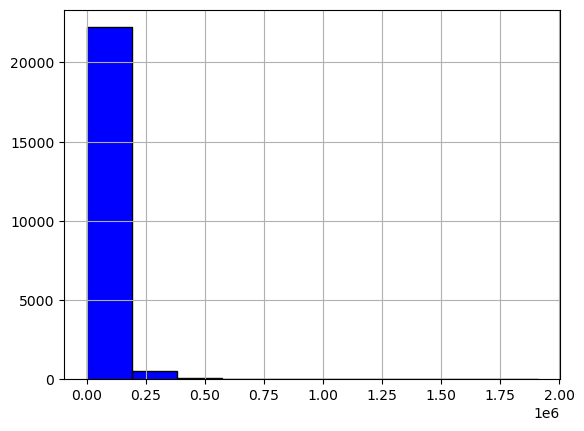

In [64]:
data['one_metrу_price'].hist(color = 'blue', edgecolor = 'black', bins = 10)

Ого! Вот бы в Москве цену за метр в 112 рублей... Почти 2 миллиона тоже выглядят загадочно, посмотрим, откуда такие цифры

In [65]:
data[data['one_metrу_price'] < 10000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,ceilng_height,first_day_exposition_year,one_metrу_price
4222,9,500000.0,52.0,2018-08-02,2,2.70,2,31.000000,1,False,...,NaN,NaN,NaN,NaN,NaN,NaN,110.0,NaN,2018,9615.384615
8451,7,12190.0,109.0,2019-03-20,2,2.75,25,32.000000,25,False,...,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0,NaN,2019,111.834862
14321,5,430000.0,54.0,2018-06-26,2,2.65,3,30.664434,3,False,...,NaN,NaN,NaN,NaN,NaN,NaN,44.0,NaN,2018,7962.962963


Двушка за 12190, да площадью в 109 метров, необычная сделка, наверное, стоит удалить данную строку, здесь явно не хватает ноликов(вопрос "сколько?").
Дальше видны какие-то значения за более чем 500к метр, посмотрим-с

In [66]:
data.loc[data['one_metrу_price'] > 500000, ['total_area', 'rooms', 'locality_name', 'cityCenters_nearest']]

,total_area,rooms,locality_name,cityCenters_nearest
1379,190.00,3,Санкт-Петербург,1197.0
1844,224.50,4,Санкт-Петербург,2335.0
2431,242.40,4,Санкт-Петербург,2242.0
4658,33.00,1,Санкт-Петербург,1376.0
4788,124.50,4,Санкт-Петербург,1722.0
5012,152.30,2,Санкт-Петербург,2389.0
5879,65.30,2,Санкт-Петербург,2380.0
6204,114.00,3,Санкт-Петербург,3400.0
7417,93.00,2,Санкт-Петербург,318.0
7544,230.00,8,Санкт-Петербург,5845.0


33 квадрата, даже не далеко от центра, за такие деньги выглядит как полное обдиралово. Дропнем строки, где площадь меньше 50 квадратов, заодно затесавшийся Всеволжск уберем. Остальное радом с центром, наверное, с крутым ремонтом, оставим

In [67]:
data = data.loc[(data['one_metrу_price'] < 500000) & (data['one_metrу_price'] > 10000)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22760 entries, 0 to 22799
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   total_images               22760 non-null  int64         
 1   last_price                 22760 non-null  float64       
 2   total_area                 22760 non-null  float64       
 3   first_day_exposition       22760 non-null  datetime64[ns]
 4   rooms                      22760 non-null  int64         
 5   ceiling_height             22760 non-null  float64       
 6   floors_total               22760 non-null  int64         
 7   living_area                22760 non-null  float64       
 8   floor                      22760 non-null  int64         
 9   is_apartment               22760 non-null  bool          
 10  studio                     22760 non-null  bool          
 11  open_plan                  22760 non-null  bool          
 12  kitc

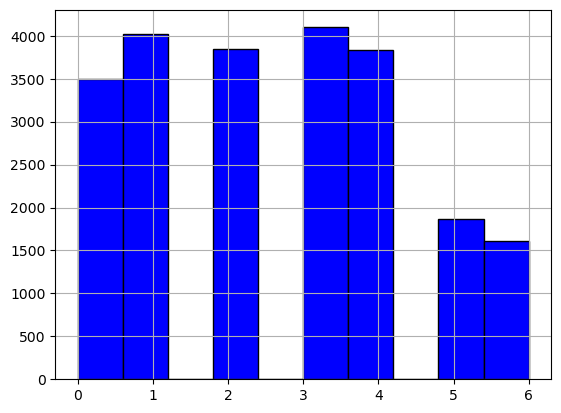

In [68]:
#Добавим день недели публикации объявления
data['first_day_exposition_day'] = data['first_day_exposition'].dt.weekday
data['first_day_exposition_day'].hist(color = 'blue', edgecolor = 'black');

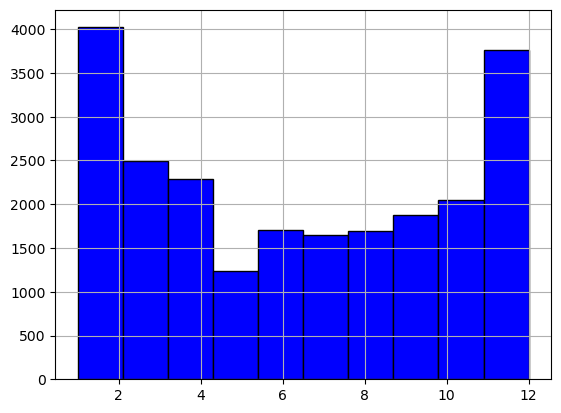

In [69]:
#Добавим месяц публикации объявления
data['first_day_exposition_month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['first_day_exposition_month'].hist(color = 'blue', edgecolor = 'black');

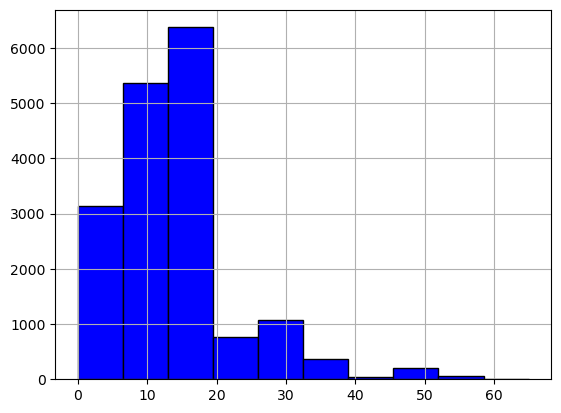

In [70]:
#Добавим расстояние в км до центра города
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']//1000)
data['cityCenters_nearest_km'].hist(color = 'blue', edgecolor = 'black');

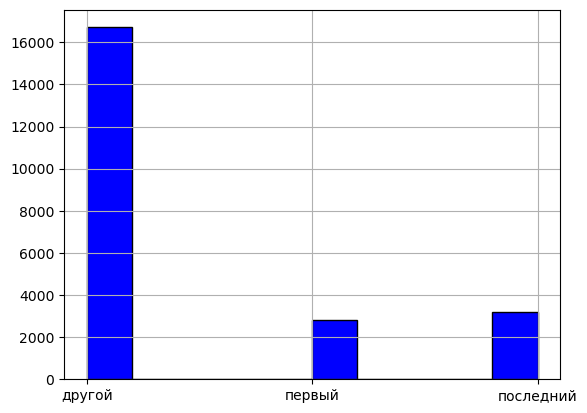

In [71]:
#Добавим тип этажа квартиры (значения — «первый», «последний», «другой»)
def type_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'
data['type_floor'] = data.apply(type_floor, axis=1)
data['type_floor'].hist(color = 'blue', edgecolor = 'black');

**Промежуточный вывод**:
 1. Мы удалили 40 строк с подозрительными ценами за квадратный метр, теперь исходная таблица "похудела" еще на одну десятую процента 
 2. Самая "популярная" цена за квадратный метро составляет около 100 тысяч рублей 
 3. Под конец недели объявления о продаже выкладывают намного реже 
 4. Январь и декабрь - самые насыщенные месяцы для публикаций 
 5. Больше всего недвижимости (из той, о который у нас есть даная информация) находится в 5-20 км от центра города
 6. Квартир на первых и последних этажах значительно меньше (удивительно, если было бы иначе) 

### Проведите исследовательский анализ данных

Посмотрим на каждый параметр еще раз и более детально. Вначале построим гистограммы для числовых данных

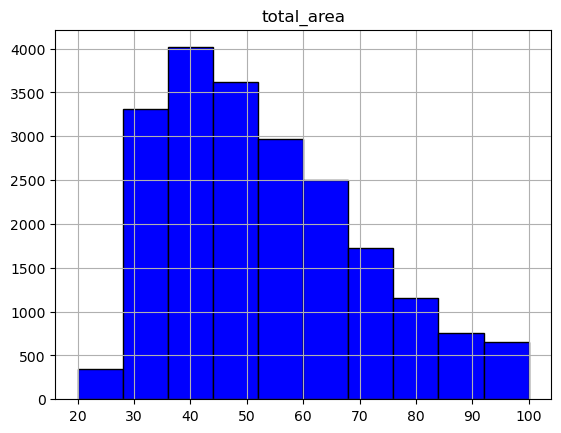

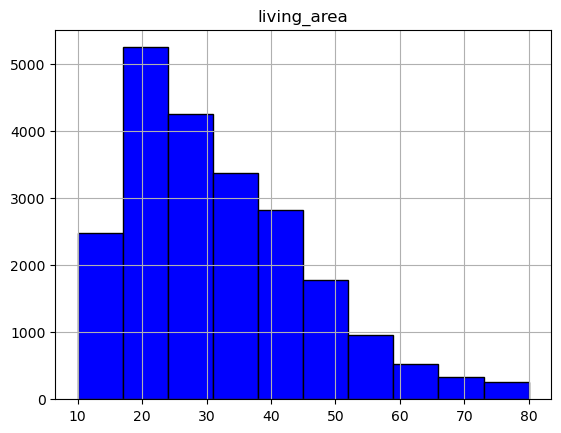

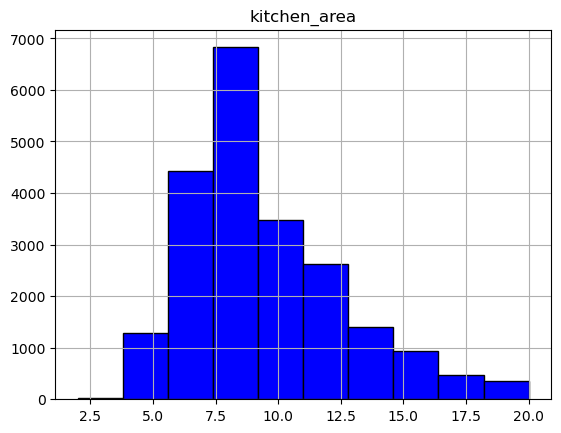

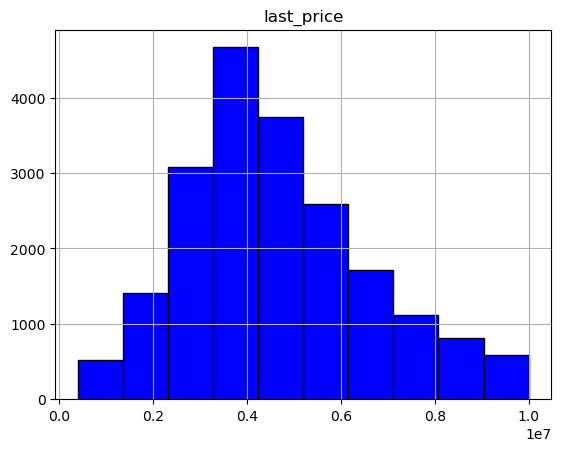

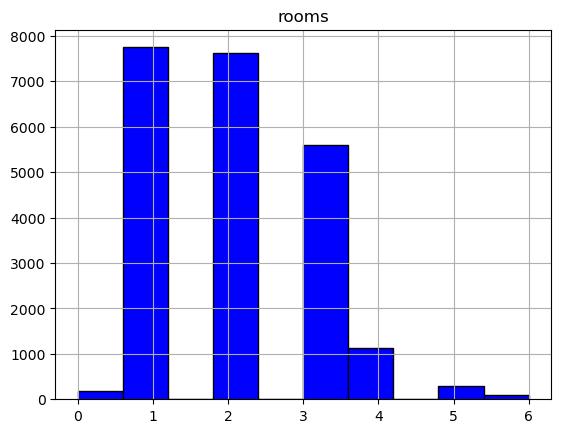

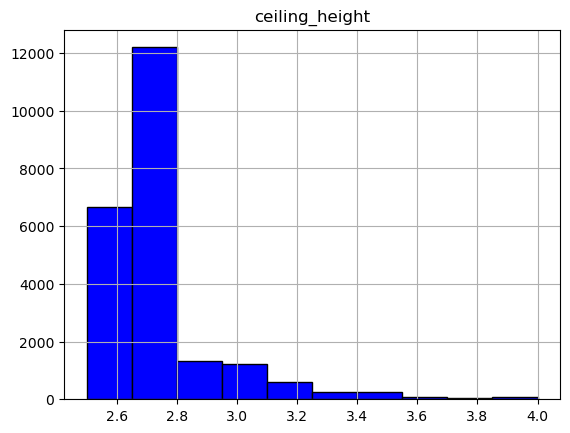

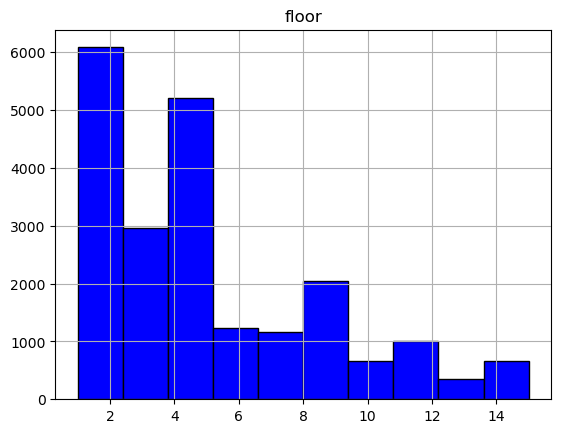

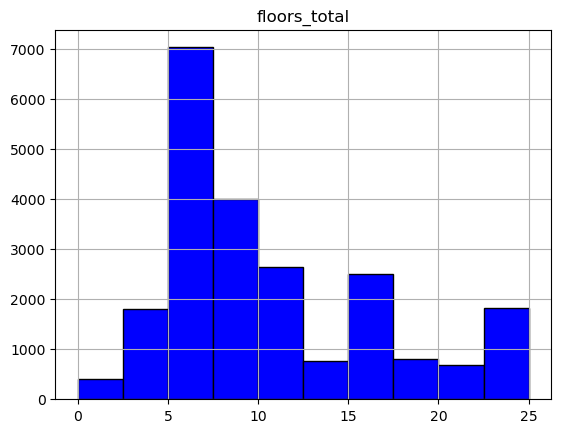

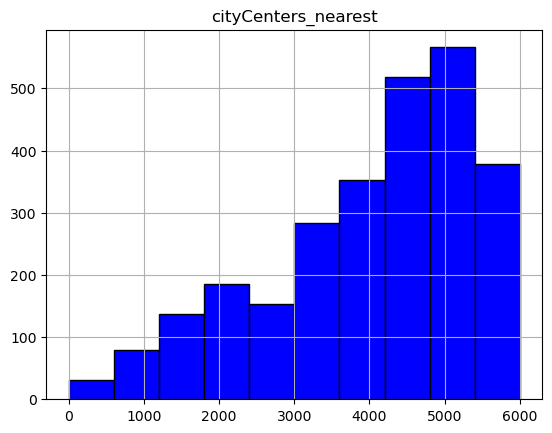

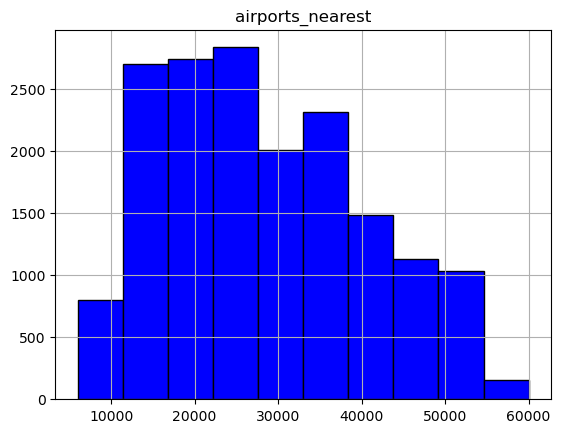

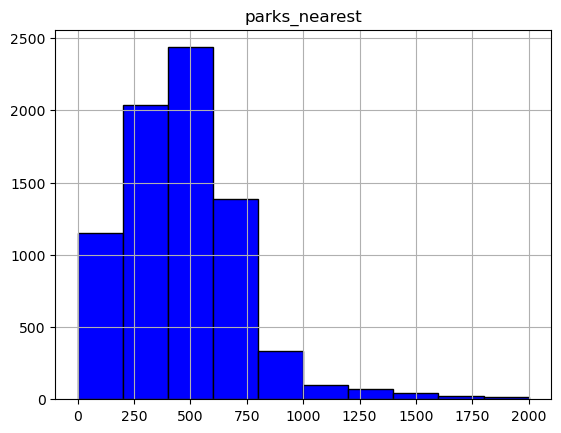

In [72]:
data.hist('total_area', color = 'blue', edgecolor = 'black', range=(20, 100));
data.hist('living_area', color = 'blue', edgecolor = 'black', range=(10, 80));
data.hist('kitchen_area', color = 'blue', edgecolor = 'black', range=(2, 20));
data.hist('last_price', color = 'blue', edgecolor = 'black', range=(400000, 10000000));
data.hist('rooms', color = 'blue', edgecolor = 'black', range=(0, 6));
data.hist('ceiling_height', color = 'blue', edgecolor = 'black', range=(2.5, 4));
data.hist('floor', color = 'blue', edgecolor = 'black', range=(1, 15));
data.hist('floors_total', color = 'blue', edgecolor = 'black', range=(0, 25));
data.hist('cityCenters_nearest', color = 'blue', edgecolor = 'black', range=(0, 6000));
data.hist('airports_nearest', color = 'blue', edgecolor = 'black', range=(6000, 60000));
data.hist('parks_nearest', color = 'blue', edgecolor = 'black', range=(0, 2000));

А теперь посмотрим на день и месяц публиций, и этаж квартир

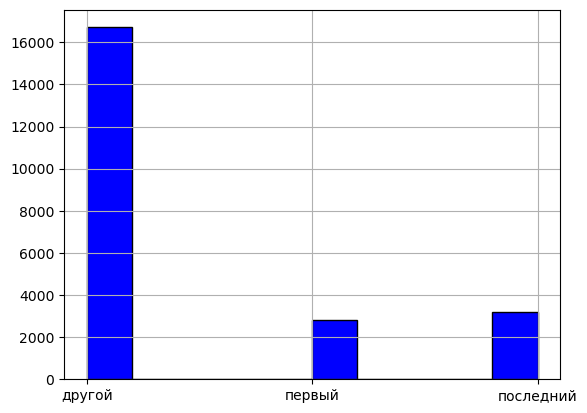

In [73]:
data['type_floor'].hist(color = 'blue', edgecolor = 'black');

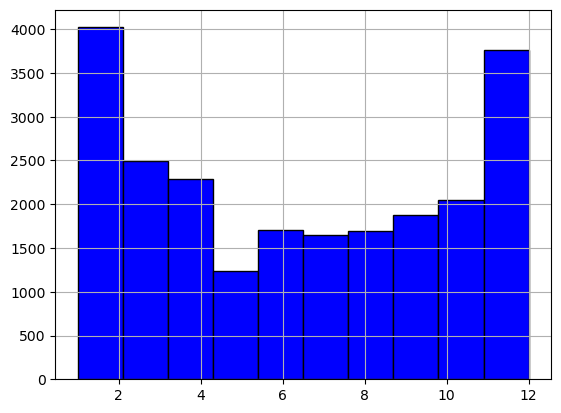

In [74]:
data['first_day_exposition_month'].hist(color = 'blue', edgecolor = 'black');

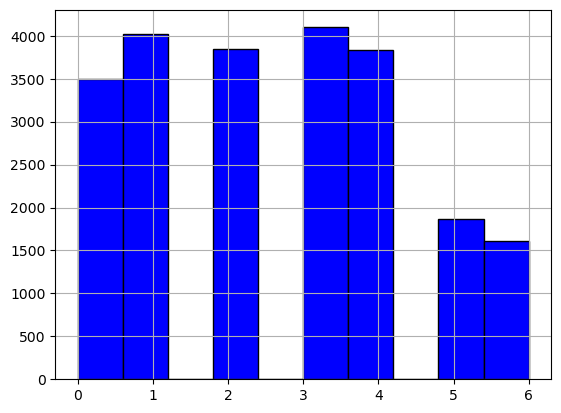

In [75]:
data['first_day_exposition_day'].hist(color = 'blue', edgecolor = 'black');

**Промежуточный итог** 
   1. **Общая площадь.**
Видно, что в целом большинство квартир имеют площадь около 40 метров
   2. **Жилая площадь.**
Стандартная жилая площадь - 15-25 метров
   3. **Кухня.**
Обычная площадь кухни - до 10 метров, есть небольшой процент счастливчиков с кухней до 20 метров
   4. **Последняя цена.**
В большей степени цена продажи составляет около 4 миллионов 
   5. **Количество комнат.**
Тут у нас большинство объявлений 1-2х комнатные квартиры, менее популярны трешки
   6. **Высота потолков.**
Норма потолков около 2,5 по всем стандартам, но у нас большинство квартир с высотой 2,6-2,8
   7. **Этаж.**
Интересная статистика, больше всего квартир располагаются на 2 и 4 этажах
   8. **Всего этажей.**
Теперь все ясно, чаще всего квартиры продают в здания с кво-м этажей от 5 до 7-8
   9. **Расстояние до центра/парка/аэропорта.**
Мы не можем здесь быть на 100% объективны, тк не видим всю полноту картины, но смело говорим что из всех имеющихся данных: много недвижимости находится в радиусе 5 км от центра, а непосредственно в 12-28 км у множества квартир находится аэропорт. Парк рядом есть вообще далеко не у всех, но тем, кому повезло, идти до него меньше километра
   10. **Тип этажа.**
Квартир на первых и последних этажах значительно меньше (удивительно, если было бы иначе) 
   11. **День недели публикации.**
Под конец недели объявления о продаже выкладывают намного реже 
   12. **Месяц публикации.**
Январь и декабрь - самые насыщенные месяцы для публикаций 

Еще раз посмотрим на скорость продажи недвижимости

Медиана 97.0


count    19623.000000
mean       173.496968
std        194.447996
min          6.000000
25%         45.000000
50%         97.000000
75%        228.000000
max       1094.000000
Name: days_exposition, dtype: float64

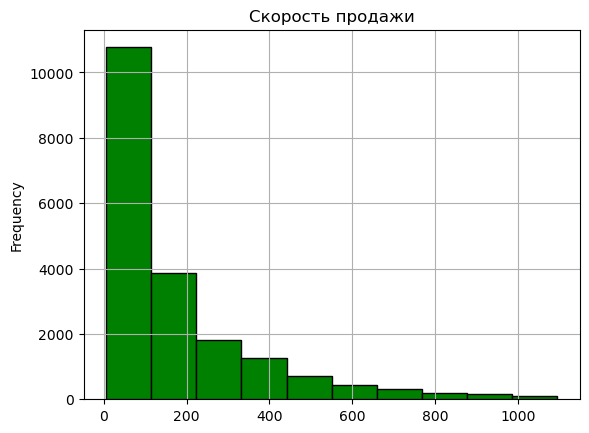

In [76]:
data['days_exposition'].plot(kind='hist', title='Скорость продажи', color = 'green', edgecolor = 'black', grid=True)
print('Медиана', data['days_exposition'].median())
data['days_exposition'].describe()

В целом, многие объявления были сняты с продажи спустя 100 дней после публикации, среднее значительно отличается от медианы(162,7 и 95 соответственно). Самые экспресс-продажи мы удалили, но у нас остались объявления, которые находились в активе всего до 45 дней, думаю найти потенциального покупателя на квартиру в такие сроки - это очень быстро, но приятно. Долгими можно считать продажи за более чем 228 дней(т.е. те, что висели дольше 75% от всех объявлений)

**Зависимость цены**
  
Посмотрим как разные параметры влияют на стоимость недвижимости, построим диаграммы рассеивания и посчитаем корреляцию

Корреляция 0.7756785468354355


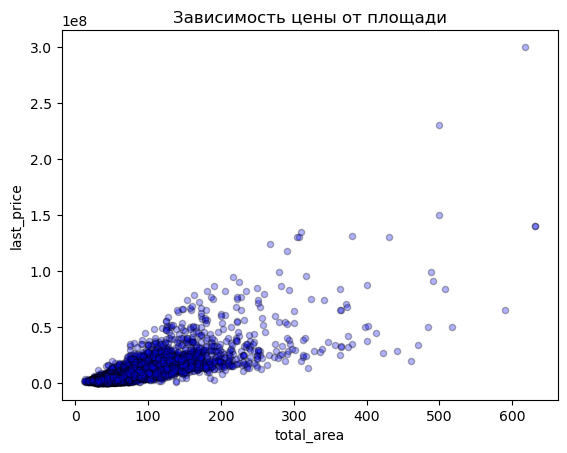

In [77]:
#Зависимость цены от площади
data.plot(y='last_price', x='total_area', kind='scatter', alpha=0.3, color = 'blue', edgecolor = 'black', title='Зависимость цены от площади')
print('Корреляция', data['last_price'].corr(data['total_area']))

Видна высокая зависимость цены от общей площади помещения

Корреляция 0.6905055983791598


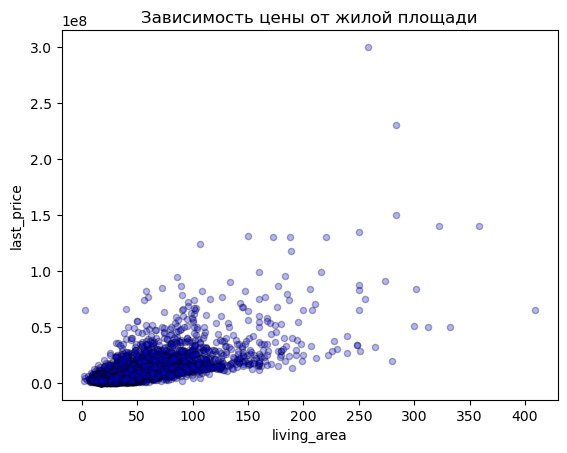

In [78]:
#Зависимость цены от жилой площади
data.plot(y='last_price', x='living_area', kind='scatter', alpha=0.3, color = 'blue', edgecolor = 'black', title='Зависимость цены от жилой площади')
print('Корреляция', data['last_price'].corr(data['living_area']))

Жилая площадь не отстает, есть средняя зависимость цены

Корреляция 0.5402100643670881


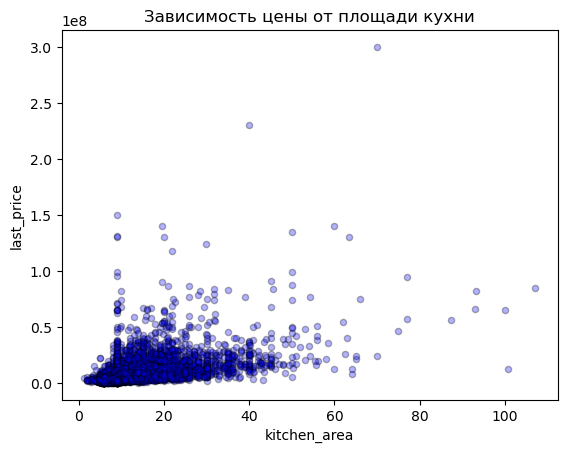

In [79]:
#Зависимость цены от площади кухни
data.plot(y='last_price', x='kitchen_area', kind='scatter', alpha=0.3, color = 'blue', edgecolor = 'black', title='Зависимость цены от площади кухни')
print('Корреляция', data['last_price'].corr(data['kitchen_area']))

Площадь кухни влияет на общую цену, но не так сильно как жилая

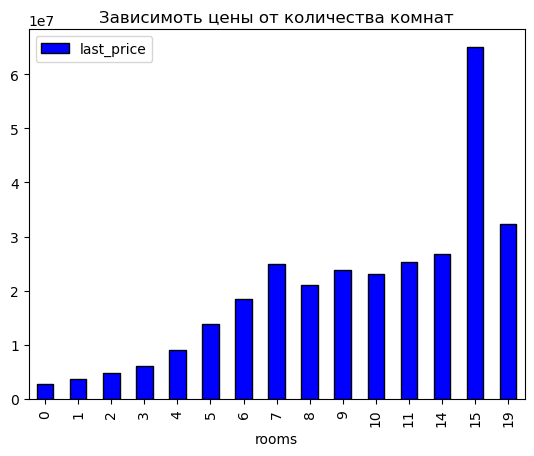

In [80]:
#Зависимоть цены от количества комнат 
(data.pivot_table(index='rooms', values='last_price', aggfunc='median')).plot(kind='bar', color = 'blue', edgecolor = 'black', title='Зависимоть цены от количества комнат');

Ничего удивительного

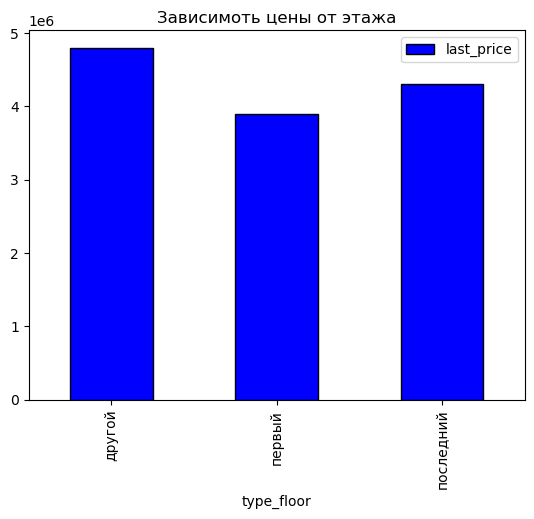

In [81]:
#Зависимоть цены от этажа 
(data.pivot_table(index='type_floor', values='last_price', aggfunc='median')).plot(kind='bar', color = 'blue', edgecolor = 'black', title='Зависимоть цены от этажа');

Невооруженным глазом видно, что первый и последние этажи однозначно дешевле

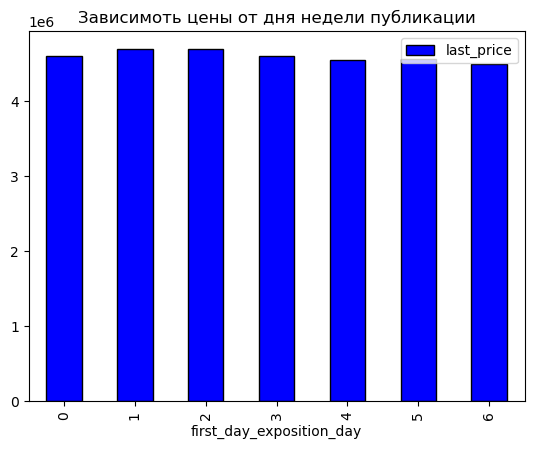

In [82]:
#Зависимоть цены от дня недели публикации 
(data.pivot_table(index='first_day_exposition_day', values='last_price', aggfunc='median')).plot(kind='bar', color = 'blue', edgecolor = 'black', title='Зависимоть цены от дня недели публикации');

А вот тут наоборот - не очень-то и влияет день недели на цену продажи

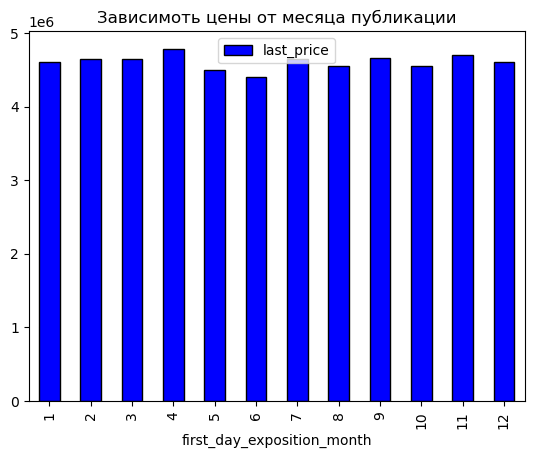

In [83]:
#Зависимоть цены от месяца публикации 
(data.pivot_table(index='first_day_exposition_month', values='last_price', aggfunc='median')).plot(kind='bar', color = 'blue', edgecolor = 'black', title='Зависимоть цены от месяца публикации');

Есть небольшое "провисание" в июне, но не сильно существенное

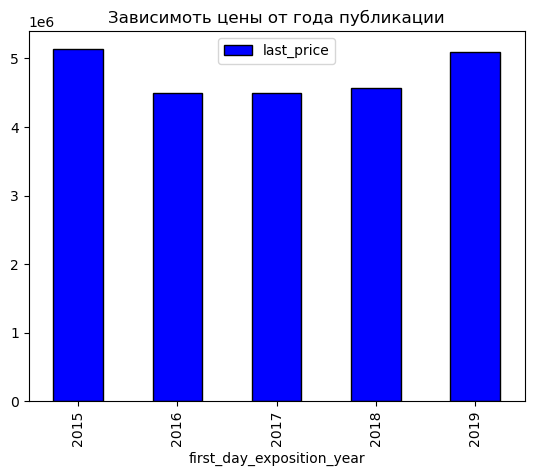

In [84]:
#Зависимоть цены от года публикации 
(data.pivot_table(index='first_day_exposition_year', values='last_price', aggfunc='median')).plot(kind='bar', color = 'blue', edgecolor = 'black', title='Зависимоть цены от года публикации');

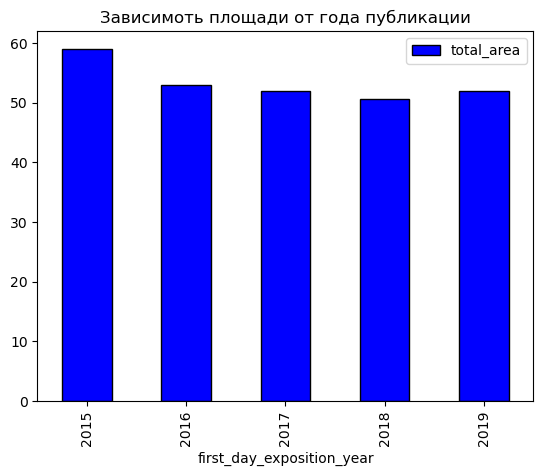

In [85]:
#Зависимоть площади от года публикации 
(data.pivot_table(index='first_day_exposition_year', values='total_area', aggfunc='median')).plot(kind='bar', color = 'blue', edgecolor = 'black', title='Зависимоть площади от года публикации');

2015 и 2019 - года с самыми дорогими квартирами. Однако, стоит заметить, что в 15 году продавались квартиры с большей площадью, чем в остальные года. А в 19 с учетом не существенной разницы по площади квартиры могли стоить дороже из-за политико-экономических 

**Промежуточный вывод**

Больше всего на цену влияет общая площадь помещения, а так же жилая площадь и, однозначно, этаж квартиры. Хоть мы и видим явные признаки зависимости цены от года публикации, но говорить о прямой стопроцентной зависимости, думаю, не стоит, тк в эти года могли продавать больше больших квартир

In [86]:
#Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 
#Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра
locality_name_top = data['locality_name'].value_counts().head(10).index
(data.loc[data['locality_name'].isin(locality_name_top)].groupby('locality_name')['one_metrу_price'].median()).sort_values(ascending=False)

locality_name
Санкт-Петербург      104623.900272
Пушкин                99865.712506
деревня Кудрово       91666.666667
поселок Парголово     91472.565784
поселок Мурино        86075.949367
поселок Шушары        76829.268293
Колпино               74722.222222
Гатчина               67796.610169
Всеволожск            65833.333333
Выборг                58158.319871
Name: one_metrу_price, dtype: float64

Самые дорогие квартиры, очевидно, в Санкт-Петербурге, самые дешевые - в Выборге

In [87]:
#Выделим квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычим среднюю цену каждого километра
dep = data[data['locality_name']=='Санкт-Петербург'].groupby('cityCenters_nearest_km')['one_metrу_price'].mean()
dep

cityCenters_nearest_km
0.0     163116.336476
1.0     139448.714790
2.0     130252.244782
3.0     122669.522169
4.0     136467.017171
5.0     141905.614262
6.0     147549.377709
7.0     139638.697758
8.0     119566.920840
9.0     110365.519088
10.0    111176.319286
11.0    106322.978765
12.0    108500.639253
13.0    107157.803900
14.0    104942.594059
15.0    101968.169629
16.0     99884.808172
17.0     94918.583602
18.0     94439.007454
19.0     95694.467279
20.0    102457.164515
21.0     91599.143432
22.0     88884.748827
23.0     92720.641577
24.0     82440.343912
25.0     90436.945589
26.0     75171.911041
27.0    132115.709459
28.0     81840.638722
29.0     62482.404228
Name: one_metrу_price, dtype: float64

<AxesSubplot:title={'center':'Цена одного км'}, xlabel='cityCenters_nearest_km'>

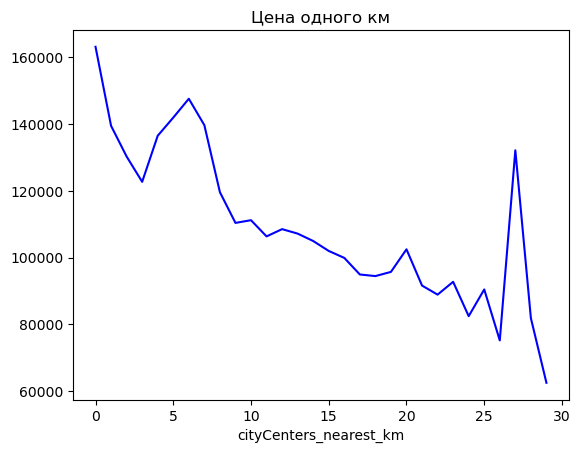

In [88]:
dep.plot(color = 'blue', title='Цена одного км');

Не совсем правильно, наверное, от цены квартиры считать цену киллометра, тк может быть студия где-нибудь прям недалеко от ценктра, а может быть коммуналка на окраине города, и вот вам такая статистика... В целом, прослеживается уменьшение цены километра по мере отдаленности от центра

### Общий вывод

**Проделанная работа**
- Мы изучили общую информацию из файла
- Построили общие гистограммы 
- Обработали выбросы и отсутствующие значения
- Для удобства анализа добавили новые колонки 
- Посмотрели, в целом, на скорость продажи квартир 
- Проанализировали и нашли зависимость между некоторыми параметрами и общей ценой недвижимости

**Вывод**
На цену стандартной квартиры в большей степени влияет ее населенный пункт, очевидно что в региональном центре ее цена будет выше, чем в селе. Также на цену влияет общая площадь, жилая площадь, сооветсвенно, количество комнат, а еще этаж на котором расположена квартира, первые самые дешевые, последние немного дороже, большинство все-таки предпочитает что-то между, отсюда разница в цене. Ещё немаловажный фактор - расстояние до центра города, чем ближе - тем дороже.

**Рекомендации**
Как минимум, надо улучшать систему по сбору информации, дорабатывать алгоритмы по заполнению подобных объявлений, улучшать сбор картографических данных, тк первоначальные данные были ужасно сырыми, в связи с чем, высока вероятность ошибок в алгоритме при автоматической обработке. Ну и еще, я бы предложила, разделять некоторые квартиры по категориям, допустим, добавить дополнительный параметр типа "коммунальная квартира", что позволит точно определить являются ли данные выбросами или все-таки реальными значениями